**Import Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Upload file**

In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/Walmart Data Analysis and Forcasting.csv'

df = pd.read_csv(file_path)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


**Data Preprocessing**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [5]:
df.shape

(6435, 8)

In [6]:
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [7]:
df.duplicated().sum()

np.int64(0)

Convert Date to datetime format and sort


In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

Extract new time features

In [9]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

Visual Inspection

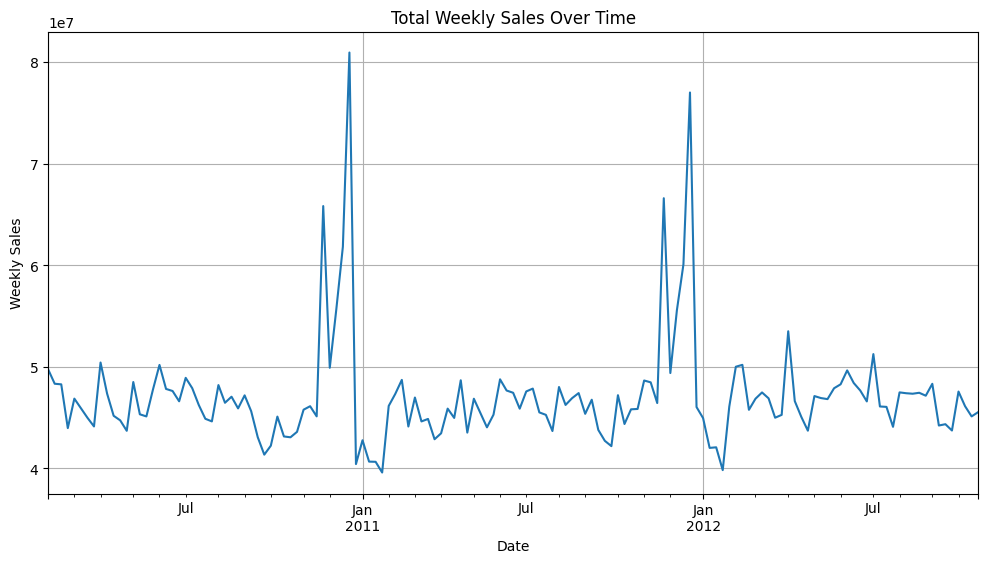

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df.groupby("Date")["Weekly_Sales"].sum().plot()
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid()
plt.show()

Check correlation

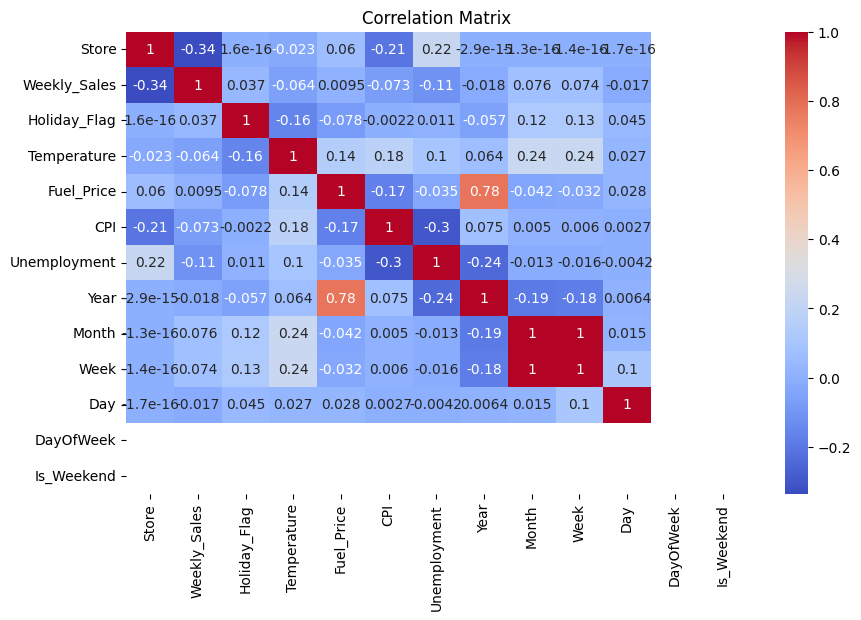

In [11]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [12]:
# Grouping by date and aggregating relevant features
weekly_df = df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Holiday_Flag': 'max',  # Holiday if any store marks it
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

In [13]:
# Extracting useful time features
weekly_df['Year'] = weekly_df['Date'].dt.year
weekly_df['Month'] = weekly_df['Date'].dt.month
weekly_df['Week'] = weekly_df['Date'].dt.isocalendar().week
weekly_df['DayOfWeek'] = weekly_df['Date'].dt.dayofweek
weekly_df['Is_Weekend'] = weekly_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [14]:
# Define features and target
X = weekly_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = weekly_df['Weekly_Sales']

In [15]:
weekly_df['Date'] = pd.to_datetime(weekly_df['Date'])
weekly_df = weekly_df.sort_values('Date')  # Important for lag features

In [16]:
# Add lag features (previous weeks' sales)
weekly_df['Lag_1'] = weekly_df['Weekly_Sales'].shift(1)
weekly_df['Lag_2'] = weekly_df['Weekly_Sales'].shift(2)
weekly_df['Lag_3'] = weekly_df['Weekly_Sales'].shift(3)

In [17]:
# Rolling averages
weekly_df['Rolling_Mean_3'] = weekly_df['Weekly_Sales'].shift(1).rolling(window=3).mean()
weekly_df['Rolling_Mean_5'] = weekly_df['Weekly_Sales'].shift(1).rolling(window=5).mean()

In [18]:
weekly_df = weekly_df.dropna().reset_index(drop=True)

In [19]:
# Create features (X) and target (y)
X = weekly_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = weekly_df['Weekly_Sales']

# Time-aware train-test split (e.g., last 20% for testing)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

**Prepare Data for Modeling**

In [20]:
# Step 7: Prepare Features and Target
X = df.drop(columns=['Weekly_Sales', 'Date'])  # Features
y = df['Weekly_Sales']                          # Target

from sklearn.model_selection import train_test_split

# Time-based split (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Check shapes
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5148, 12)
Test set shape: (1287, 12)


In [21]:
# Step 8: Train XGBoost Model
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

# Fit model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 9: Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manual square root
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📉 RMSE: 123042.96
📈 R² Score: 0.9467


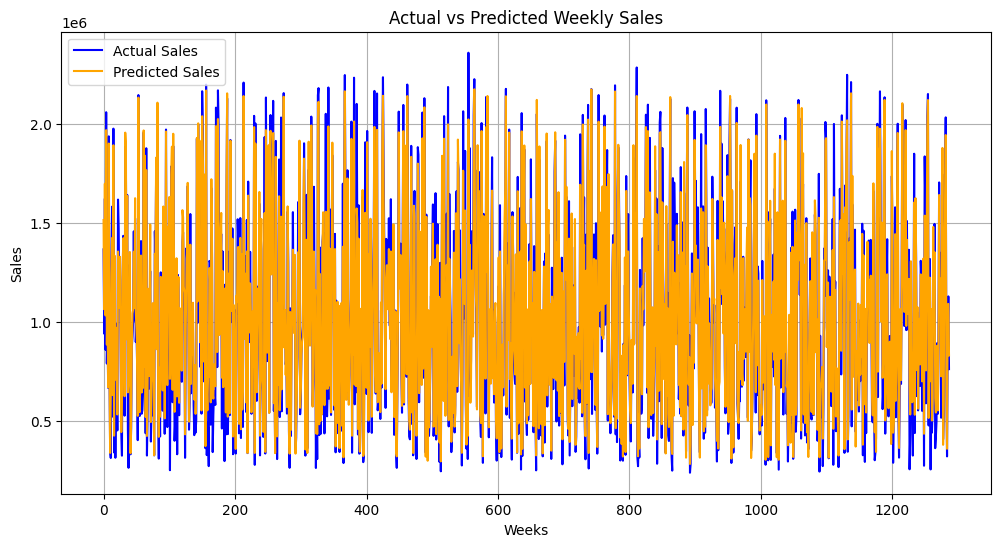

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(y_pred, label='Predicted Sales', color='orange')
plt.title("Actual vs Predicted Weekly Sales")
plt.xlabel("Weeks")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


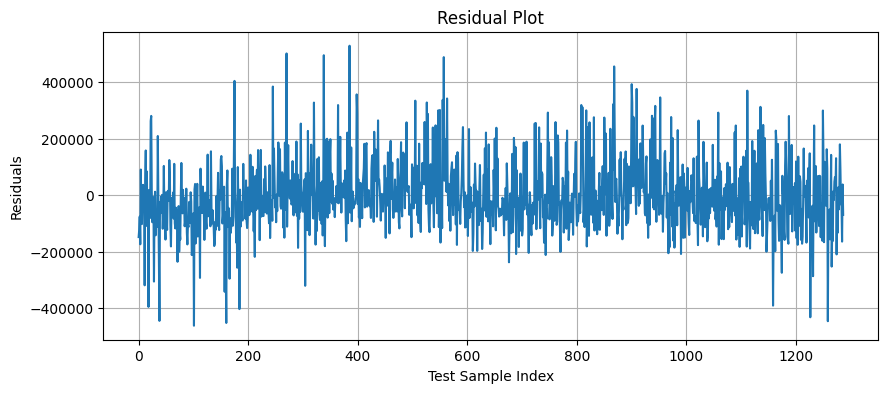

In [24]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
plt.plot(residuals.values)
plt.title("Residual Plot")
plt.xlabel("Test Sample Index")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


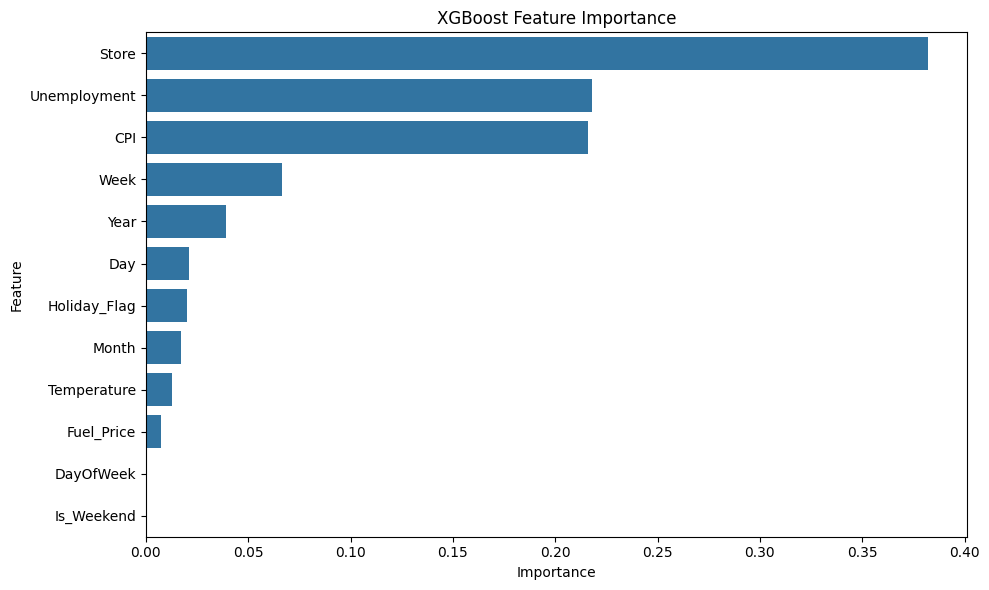

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()
